In [149]:
import geopandas as gpd
from shapely.geometry import Point, MultiPoint, MultiLineString, LineString
from shapely.ops import split, nearest_points

In [165]:
# load NG raw buses data
ng_buses = gpd.read_file("/home/matin/Downloads/all_raw_substations.geojson")
ng_lines = gpd.read_file("/home/matin/Downloads/all_raw_lines.geojson")

ng_lines['id'] = ng_lines['id'].astype(int)
ng_buses['id'] = ng_buses['id'].astype(int)





In [166]:
us_buses = gpd.read_file("/home/matin/Downloads/all_raw_substations (1).geojson")
us_lines = gpd.read_file("/home/matin/Downloads/all_raw_lines (1).geojson")

us_lines['id'] = us_lines['id'].astype(int)
us_buses['id'] = us_buses['id'].astype(int)

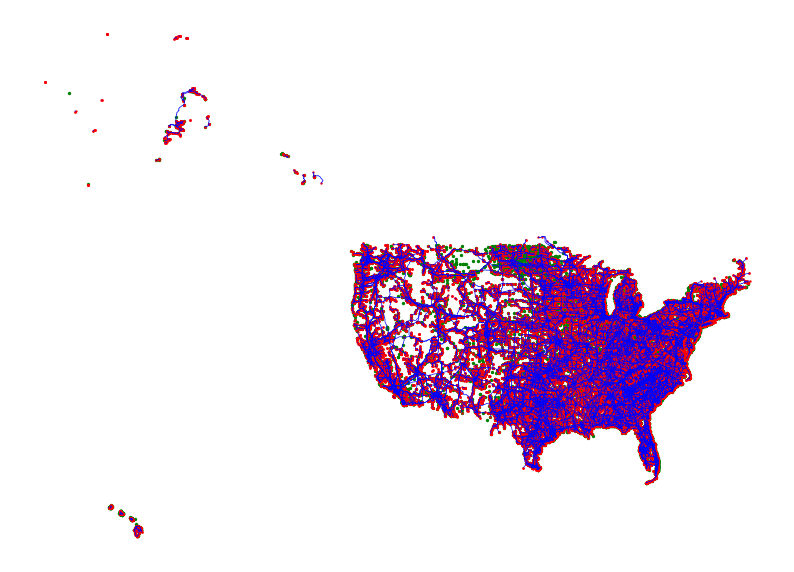

In [168]:
buses = us_buses
lines = us_lines
tol = 1 #meters

# plot buses and lines on the same map

import matplotlib.pyplot as plt
ax = buses.plot(figsize=(10, 10), color='green', markersize=2)
lines.plot(ax=ax, color='blue', linewidth=0.5)
# plot start and end points of lines
lines_start = lines.copy()
lines_start.geometry = lines_start.geometry.apply(lambda x: Point(x.coords[0]))
lines_start.plot(ax=ax, color='red', markersize=0.5)
lines_end = lines.copy()
lines_end.geometry = lines_end.geometry.apply(lambda x: Point(x.coords[-1]))
lines_end.plot(ax=ax, color='red', markersize=1)
ax.set_axis_off()
plt.show()



In [169]:
# copied over function from build osm network
import pandas as pd
from tqdm import tqdm

def _split_linestring_by_point(linestring, points):
    """
    Function to split a linestring geometry by multiple inner points.

    Parameters
    ----------
    lstring : LineString
        Linestring of the line to be split
    points : list
        List of points to split the linestring

    Return
    ------
    list_lines : list
        List of linestring to split the line
    """

    list_linestrings = [linestring]

    for p in points:
        # execute split to all lines and store results
        temp_list = [split(l, p) for l in list_linestrings]
        # nest all geometries
        list_linestrings = [lstring for tval in temp_list for lstring in tval.geoms]

    return list_linestrings

def line_endings_to_bus_conversion(lines):
    # Assign to every line a start and end point

    lines["bounds"] = lines["geometry"].boundary  # create start and end point

    lines["bus_0_coors"] = lines["bounds"].map(lambda p: p.geoms[0])
    lines["bus_1_coors"] = lines["bounds"].map(lambda p: p.geoms[1])

    # splits into coordinates
    lines["bus0_lon"] = lines["bus_0_coors"].x
    lines["bus0_lat"] = lines["bus_0_coors"].y
    lines["bus1_lon"] = lines["bus_1_coors"].x
    lines["bus1_lat"] = lines["bus_1_coors"].y

    return lines

def fix_overpassing_lines(lines, buses, distance_crs, tol=1):
    """
    Function to avoid buses overpassing lines with no connection when the bus
    is within a given tolerance from the line.

    Parameters
    ----------
    lines : GeoDataFrame
        Geodataframe of lines
    buses : GeoDataFrame
        Geodataframe of substations
    tol : float
        Tolerance in meters of the distance between the substation and the line
        below which the line will be split
    """

    lines_to_add = []  # list of lines to be added
    lines_to_split = []  # list of lines that have been split

    lines_epsgmod = lines.to_crs(distance_crs)
    buses_epsgmod = buses.to_crs(distance_crs)

    # set tqdm options for substation ids
    tqdm_kwargs_substation_ids = dict(
        ascii=False,
        unit=" lines",
        total=lines.shape[0],
        desc="Verify lines overpassing nodes ",
    )

    for l in tqdm(lines.index, **tqdm_kwargs_substation_ids):
        # bus indices being within tolerance from the line
        bus_in_tol_epsg = buses_epsgmod[
            buses_epsgmod.geometry.distance(lines_epsgmod.geometry.loc[l]) <= tol
        ]

        # exclude endings of the lines
        try:
            bus_in_tol_epsg = bus_in_tol_epsg[
                (
                    (
                        bus_in_tol_epsg.geometry.distance(
                            lines_epsgmod.geometry.loc[l].boundary.geoms[0]
                        )
                        > tol
                    )
                    | (
                        bus_in_tol_epsg.geometry.distance(
                            lines_epsgmod.geometry.loc[l].boundary.geoms[1]
                        )
                        > tol
                    )
                )
            ]
        except IndexError:
            print(f'Index not found for line {l}')

        if not bus_in_tol_epsg.empty:
            # add index of line to split
            lines_to_split.append(l)

            buses_locs = buses.geometry.loc[bus_in_tol_epsg.index]

            # get new line geometries
            new_geometries = _split_linestring_by_point(lines.geometry[l], buses_locs)
            n_geoms = len(new_geometries)

            # create temporary copies of the line
            df_append = gpd.GeoDataFrame([lines.loc[l]] * n_geoms)
            # update geometries
            df_append["geometry"] = new_geometries
            # update name of the line
            df_append["line_id"] = [
                str(df_append["line_id"].iloc[0]) + f"_{id}" for id in range(n_geoms)
            ]

            lines_to_add.append(df_append)

    if not lines_to_add:
        return lines, buses

    df_to_add = gpd.GeoDataFrame(pd.concat(lines_to_add, ignore_index=True))
    df_to_add.set_crs(lines.crs, inplace=True)
    df_to_add.set_index(lines.index[-1] + df_to_add.index, inplace=True)

    # update length
    df_to_add["length"] = df_to_add.to_crs(distance_crs).geometry.length

    # update line endings
    df_to_add = line_endings_to_bus_conversion(df_to_add)

    # remove original lines
    lines.drop(lines_to_split, inplace=True)

    lines = gpd.GeoDataFrame(
        pd.concat([lines, df_to_add], ignore_index=True).reset_index(drop=True),
        crs=lines.crs,
    )

    return lines, buses


# TODO: fix the running of the following lines
lines_copy = lines.copy()
lines_copy['line_id'] = lines_copy['id']
lines_slow, buses_slow = fix_overpassing_lines(lines_copy, buses.copy(), distance_crs = 'EPSG:3857', tol=tol)
lines_slow
# for us the average speed is around 10 lines pers second
# for 174222 lines it will take approx 5 hours

Verify lines overpassing nodes :   4%|▎         | 6397/174222 [07:32<3:17:55, 14.13 lines/s] 


KeyboardInterrupt: 

In [313]:
distance_crs = "EPSG:3857"
tolerance = 5 # meters

df_l = lines.copy()
df_p = buses.copy()

# change crs to distance based
df_l = df_l.to_crs(distance_crs)
df_p = df_p.to_crs(distance_crs)

# Buffer points to create areas for spatial join 
buffer_df = gpd.GeoDataFrame(geometry=df_p.buffer(tolerance))
    
# Spatial join to find lines intersecting point buffers
joined = gpd.sjoin(df_l, buffer_df, how="inner", op='intersects')    

    

/home/matin/PRs/pypsa-africa/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [314]:
group_lines = joined.groupby('id')

In [315]:

for i, group in group_lines:
    line_id = group['id'].iloc[0] # pick the line id that represents the group
    line_geom = df_l[df_l['id'] == line_id]['geometry'].iloc[0]

    # number of points that intersect with the line
    num_points = len(group)

    # get the indeces of the points that intersect with the line
    points_indexes = group['index_right'].tolist()
    
    # get the geometries of the points that intersect with the line
    multi_points = df_p.loc[points_indexes, 'geometry'].tolist()

    # finda all the nearest points on the line to the points that intersect with the line
    nearest_points_list = [nearest_points(line_geom, point)[0] for point in multi_points]
    
    # create perpendicular lines from the points that intersect with the line to the nearest points on the line
    perpendicular_lines = [LineString([point, nearest_point]) for point, nearest_point in zip(multi_points, nearest_points_list)]

    # split the line geom with the perpendicular lines using difference
    split_line = line_geom.difference(MultiLineString(perpendicular_lines))

    df_l.loc[df_l['id'] == line_id, 'geometry'] = split_line

    if len(multi_points) > 1:
        break


    


In [316]:
# splitting for one point as an example

# point = multi_points[0]
# for testing using the mean point to get a point in the middle
point = MultiPoint(multi_points).centroid

print(point)

# Find the nearest point on the line to the given point
nearest_point = nearest_points(line_geom, point)[0]
print(nearest_point)

#  create the perpendicular line
perpendicular_line = LineString([point, nearest_point])

# split the line by the perpendicular line
split_line = line_geom.difference(perpendicular_line)
print(split_line) # geometrycollection

# results in a linestring if the split is at the start or end
# otherwise results in a multilinestring
# print(len(split_line.geoms))


POINT (-12708725.814166114 4069472.8665445102)
POINT (-12708131.124059757 4069443.611744909)
LINESTRING (-12709475.962206751 4067744.797115119, -12709450.05816126 4067679.2884070682, -12709335.977947079 4067647.59860455, -12709086.844926665 4067881.420773986, -12708881.916876102 4068074.0171226864, -12708524.982060779 4068404.8366883243, -12708298.391237294 4068593.4264923222, -12708245.046937304 4068780.321602771, -12708146.373340666 4069133.625123573, -12708115.960855782 4069751.8485985966, -12708122.562101586 4070314.985960453, -12708090.635671644 4070555.682600859, -12708021.116649654 4071057.46935035, -12707983.435001992 4071173.2155419826, -12707978.581472194 4071201.801852927)


<Axes: >

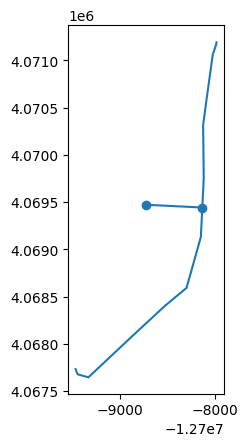

In [317]:
# for testing plotting the geometries
# put point, nearest_point, perpendicular_line, split_line in a dataframe
df = gpd.GeoDataFrame(columns=['geometry'])
df.loc[0, 'geometry'] = point
df.loc[1, 'geometry'] = nearest_point
df.loc[2, 'geometry'] = perpendicular_line
df.loc[3, 'geometry'] = split_line

df.plot()

[<POINT (-12709474.793 4067745.254)>, <POINT (-12709100.304 4068609.06)>, <POINT (-12708725.814 4069472.867)>, <POINT (-12707976.835 4071200.479)>]
[<POINT (-12709475.96 4067744.793)>, <POINT (-12708732.64 4068212.372)>, <POINT (-12708131.124 4069443.612)>, <POINT (-12707978.751 4071200.804)>]
[<LINESTRING (-12709474.793 4067745.254, -12709475.96 4067744.793)>, <LINESTRING (-12709100.304 4068609.06, -12708732.64 4068212.372)>, <LINESTRING (-12708725.814 4069472.867, -12708131.124 4069443.612)>, <LINESTRING (-12707976.835 4071200.479, -12707978.751 4071200.804)>]
LINESTRING (-12709475.962206751 4067744.797115119, -12709450.05816126 4067679.2884070682, -12709335.977947079 4067647.59860455, -12709086.844926665 4067881.420773986, -12708881.916876102 4068074.0171226864, -12708524.982060779 4068404.8366883243, -12708298.391237294 4068593.4264923222, -12708245.046937304 4068780.321602771, -12708146.373340666 4069133.625123573, -12708115.960855782 4069751.8485985966, -12708122.562101586 407031

<Axes: >

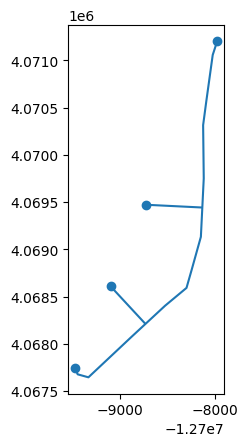

In [318]:
test_points = [
    multi_points[0],
    MultiPoint([multi_points[0], MultiPoint(multi_points).centroid]).centroid,
    MultiPoint(multi_points).centroid,
    multi_points[-1]
]


# finda all the nearest points on the line to the points that intersect with the line
nearest_points_list = [nearest_points(line_geom, point)[0] for point in test_points]

# create perpendicular lines from the points that intersect with the line to the nearest points on the line
perpendicular_lines = [LineString([point, nearest_point]) for point, nearest_point in zip(test_points, nearest_points_list)]


split_line = line_geom.difference(MultiLineString(perpendicular_lines))

print(test_points)
print(nearest_points_list)
print(perpendicular_lines)
print(line_geom)
print(split_line)

df1 = gpd.GeoDataFrame(columns=['geometry'])
df1.loc[0, 'geometry'] = line_geom
df1.loc[1, 'geometry'] = MultiLineString(perpendicular_lines)
df1.loc[2, 'geometry'] = MultiPoint(test_points)

df1.plot()


/tmp/ipykernel_39962/3832290922.py:5: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  df2.explode().plot(color=['red', 'green', 'blue', 'black'])


<Axes: >

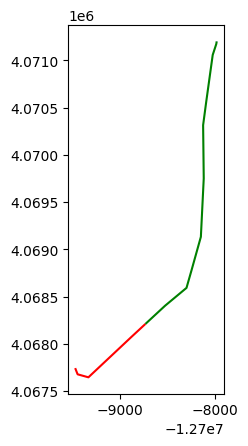

In [319]:
df2 = gpd.GeoDataFrame(columns=['geometry'])
df2.loc[0, 'geometry'] = split_line

# plot each line in the multilinestring a different color
df2.explode().plot(color=['red', 'green', 'blue', 'black'])


In [320]:
len(split_line.geoms)

3

In [321]:
# subset df_l for geom type MultiLineString
df_l[df_l['geometry'].geom_type == 'MultiLineString']


,id,tags.power,Type,Country,Length,tags.cables,tags.voltage,tags.circuits,tags.frequency,geometry
176,5426045,line,Way,US,6411.069534,NaN,NaN,NaN,NaN,"MULTILINESTRING ((-12201042.378 5667525.874, -..."
313,5629575,line,Way,US,318.769765,NaN,NaN,NaN,NaN,"MULTILINESTRING ((-8209981.396 5347718.093, -8..."
414,5751488,line,Way,US,3490.457318,NaN,NaN,NaN,NaN,"MULTILINESTRING ((-12462806.988 5872641.861, -..."
518,5837797,line,Way,US,53037.566189,3,115000,NaN,NaN,"MULTILINESTRING ((-13292133.710 5825654.512, -..."
910,7105173,line,Way,US,10357.401055,3,230000,NaN,60,"MULTILINESTRING ((-12706238.157 4068320.015, -..."
911,7118738,line,Way,US,4236.649906,3,NaN,NaN,NaN,"MULTILINESTRING ((-12709475.962 4067744.797, -..."


In [323]:
print(len(lines))
print(len(df_l))
print(len(df_l[df_l['geometry'].geom_type == 'MultiLineString']))
print(len(df_l.explode(index_parts=False)))


174222
174222
6
174228


In [328]:
def fix_overpassing_lines(lines, buses, distance_crs, tol=1):
    df_l = lines.copy() # can use lines directly without copying
    # drop all columns excpet id and geometry for buses
    df_p = buses[['id', 'geometry']].copy()

    # change crs to distance based
    df_l = df_l.to_crs(distance_crs)
    df_p = df_p.to_crs(distance_crs)

    # Buffer points to create areas for spatial join 
    buffer_df = gpd.GeoDataFrame(geometry=df_p.buffer(tolerance))
        
    # Spatial join to find lines intersecting point buffers
    joined = gpd.sjoin(df_l, buffer_df, how="inner", op='intersects')

    # group lines by their ids
    group_lines = joined.groupby('id')

    # iterate over the groups, TODO: change to apply
    for i, group in group_lines:
        line_id = group['id'].iloc[0] # pick the line id that represents the group
        line_geom = df_l[df_l['id'] == line_id]['geometry'].iloc[0]

        # number of points that intersect with the line
        num_points = len(group)

        # get the indeces of the points that intersect with the line
        points_indexes = group['index_right'].tolist()
        
        # get the geometries of the points that intersect with the line
        multi_points = df_p.loc[points_indexes, 'geometry'].tolist()

        # finda all the nearest points on the line to the points that intersect with the line
        nearest_points_list = [nearest_points(line_geom, point)[0] for point in multi_points]
        
        # create perpendicular lines from the points that intersect with the line to the nearest points on the line
        perpendicular_lines = [LineString([point, nearest_point]) for point, nearest_point in zip(multi_points, nearest_points_list)]

        # split the line geom with the perpendicular lines using difference
        split_line = line_geom.difference(MultiLineString(perpendicular_lines))

        # TODO: replace the end points of each line in the multistring with the points that intersect with the line

        # replace the line with the split line
        df_l.loc[df_l['id'] == line_id, 'geometry'] = split_line


    # explode the multilinestrings (not recommended, but inculded for completion)
    df_l = df_l.explode(index_parts=False)

    # update line endings (not recommended, but inculded for completion)
    # commented out due to errors
    # df_l = line_endings_to_bus_conversion(df_l)

    # update length
    df_l["length"] = df_l.to_crs(distance_crs).geometry.length

    # return to original crs
    df_l = df_l.to_crs(lines.crs)

    # buses should not be returned as they are not changed, but included for completion
    return df_l, buses

In [329]:
lines_fast, buses_fast = fix_overpassing_lines(lines.copy(), buses.copy(), distance_crs = 'EPSG:3857', tol=tol)

/home/matin/PRs/pypsa-africa/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
